# Exploring the Posterior using MCMC
In this notebook, we use `pyross.inference.mcmc_latent_inference` to explore the posterior distribution of a SIR model given synthetic data and compare the result to a MAP estimate.

Pyross supports parallel MCMC on the posterior using the Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler as implemented in the `emcee` Python library.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

## 1) Generate a trajectory from the SEIR model
We generate a test trajectory on a population with two ages groups.

In [2]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])


def contactMatrix(t):   
    return C

# duration of simulation and data file
Tf = 100;  
Nt=Tf+1; 

beta = 0.02
alpha = 0.2
gIa = 1/7 
gIs = 1/7 
fsa = 1


# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']

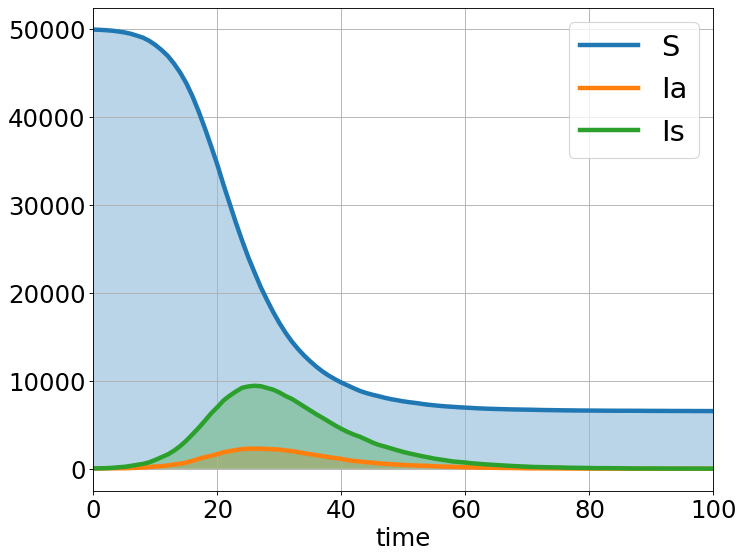

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) MCMC
We take the first 20 data points and run MCMC on the posterior of the SIR model given the data.

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
x = (data_array[:Nf_inference]).astype('float')

In [5]:
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}

model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"]]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}

In [6]:
# a filter that sums over all the infected people for each age group
fltr = np.kron([0, 1, 1],np.identity(M))
print(fltr)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# initialise the estimator 
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni, lyapunov_method='euler')

# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)
print(logp) 

[[0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]
172.9069181854347


In [7]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4
param_priors = {
    'betaIa':{
        'mean': 0.005, 
        'std': 0.003, 
        'bounds': [eps, 5]
    }, 
    'betaIs':{
        'mean': 0.02,  
        'std': 0.02, 
        'bounds': [eps, 5]
    }, 
    'gIa':{
        'mean': 0.2, 
        'std': 0.1,
        'bounds': [eps, 5]
    }, 
    'gIs':{
        'mean': 0.15,
        'std': 0.1, 
        'bounds': [eps, 5]
    }
}

Ia0_g = (Ia0+3)
Ia0_std = Ia0_g
Ia0_b = np.array([[0.1, 500]]*M)

S0_g = (S0-3)
S0_std = Ia0_std*3
S0_b = [(100, N) for N in Ni]

init_priors = {
    'independent':{
        'fltr': np.repeat([True, True, False], M), 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S0_std, *Ia0_std], 
        'bounds': [*S0_b, *Ia0_b]
    }
}

estimator.set_lyapunov_method('euler')
sampler = estimator.mcmc_latent_inference(obs, fltr, Tf_inference, contactMatrix, param_priors,
                              init_priors, tangent=True, verbose=True, nprocesses=4, nsamples=1000) 

  0%|          | 0/1000 [00:00<?, ?it/s]/home/paul/Sys/Programme/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]


The function `estimator.mcmc_latent_inference` returns the current state of the Markov chain given by the `emcee` algorithm. This can be used to inspect the convergence, for example by looking at a trace plot of all variables.

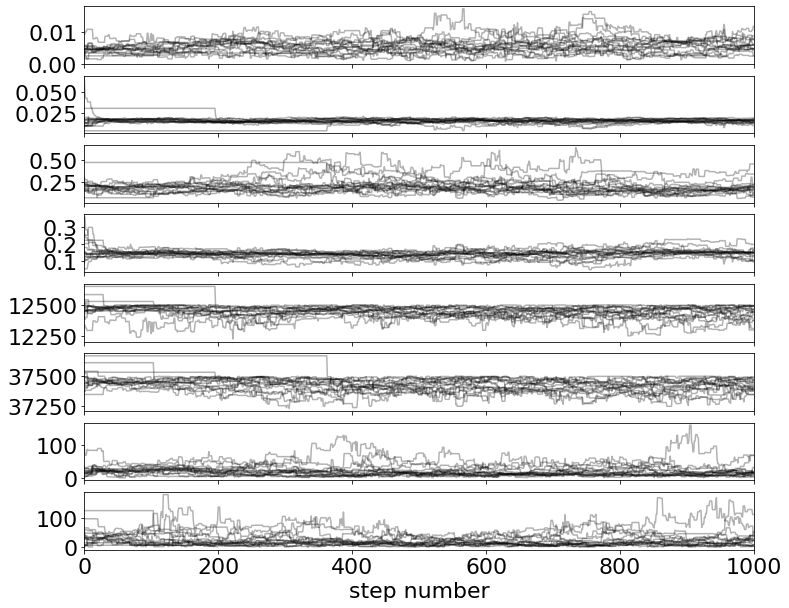

In [8]:
fig, axes = plt.subplots(8, figsize=(12, 10), sharex=True)
samples = sampler.get_chain()
for i in range(8):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
axes[-1].set_xlabel("step number");

If we now decide to continue running this chain, we can call `estimator.mcmc_latent_inference` again and including the current state with `sampler=sampler`.

In [9]:
sampler = estimator.mcmc_latent_inference(obs, fltr, Tf_inference, contactMatrix, param_priors,
                              init_priors, tangent=True, verbose=True, nprocesses=4, nsamples=2000,
                              sampler=sampler) 

100%|██████████| 2000/2000 [06:32<00:00,  5.10it/s]


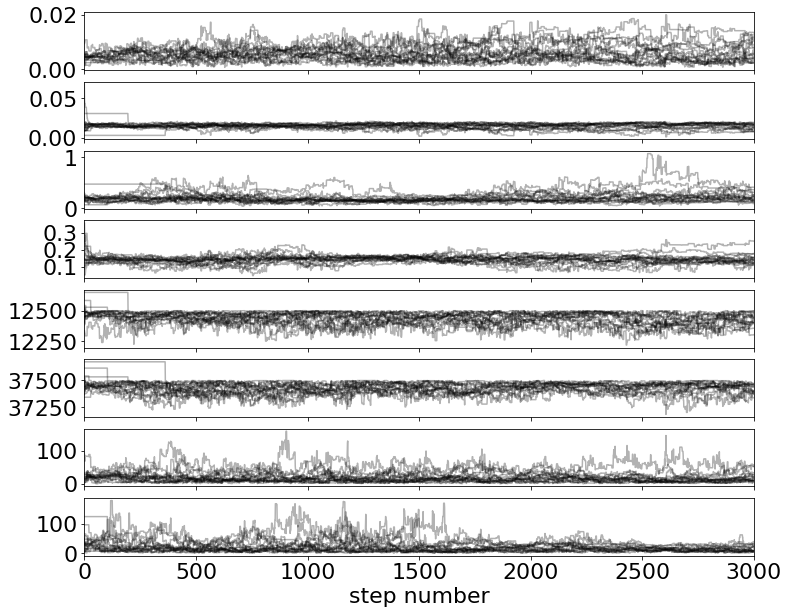

In [10]:
fig, axes = plt.subplots(8, figsize=(12, 10), sharex=True)
samples = sampler.get_chain()
for i in range(8):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
axes[-1].set_xlabel("step number");

We now decide that this looks good. To finalise the MCMC run, we can use the function `estimator.mcmc_latent_inference_process_result`.
By specifying the `discard` argument, we can discard the burn-in period in each chain.

In [11]:
result = estimator.mcmc_latent_inference_process_result(sampler, obs, fltr, param_priors,init_priors, 
                                                        discard=500)
post_mean = pyross.utils.posterior_mean(result)
print(post_mean['map_params_dict'])

{'betaIa': 0.0060410134965883855, 'betaIs': 0.014950407397838325, 'gIa': 0.2017731205655821, 'gIs': 0.14437739882656606}


## 3) MAP
In addition to the posterior samples (and thus the posterior mean), we compute the MAP estimate.

In [12]:
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]
ftol=1e-6
result2 = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors,
                                            tangent=True, global_max_iter=250, local_max_iter=1000, global_atol=1.0, 
                                            cma_population=50, verbose=True, ftol=ftol) 

Starting global minimisation...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 8 (seed=90316610, Mon Jul  6 11:03:07 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 1.843395462419717e+02 1.0e+00 1.27e+00  4e-03  9e+01 0:00.5
    2    100 1.877438763239232e+02 1.3e+00 1.43e+00  5e-03  1e+02 0:01.2
    3    150 2.208447274476091e+02 1.6e+00 1.56e+00  5e-03  1e+02 0:02.1
   12    600 1.841317154283713e+02 4.6e+00 8.42e-01  3e-03  6e+01 0:05.5
   19    950 1.793728461457613e+02 1.5e+01 5.10e-01  1e-03  4e+01 0:09.9
   30   1500 1.783554116799686e+02 5.9e+01 4.50e-01  7e-04  3e+01 0:15.1
   47   2350 1.778956501582910e+02 1.2e+02 4.45e-01  5e-04  2e+01 0:21.1
   53   2650 1.778844781024492e+02 1.5e+02 3.28e-01  3e-04  1e+01 0:23.3
Optimal value (global minimisation):  177.88447810244918
Starting local minimisation...
Optimal value (local minimisation):  177.88308152049188


## 4) Plot result

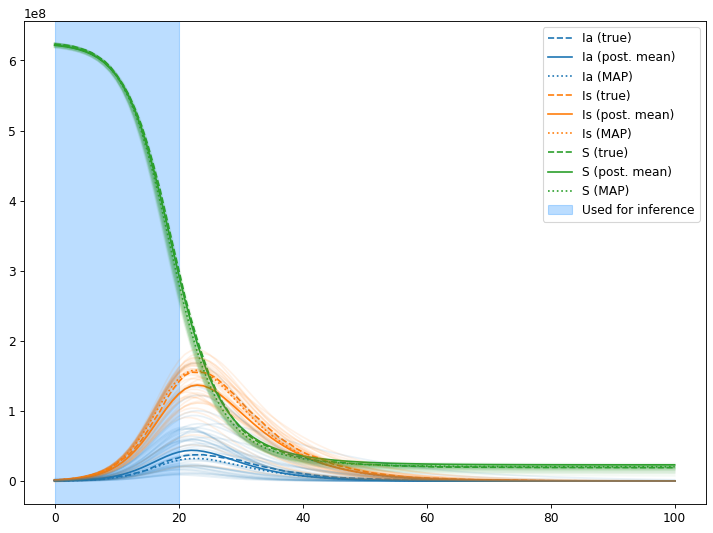

In [13]:
estimator.set_params(post_mean['map_params_dict'])
estimator.set_det_model(post_mean['map_params_dict'])
x_pm = estimator.integrate(post_mean['map_x0'], 0, Tf, Nf, method='LSODA') * N
estimator.set_params(result2['map_params_dict'])
estimator.set_det_model(result2['map_params_dict'])
x_map = estimator.integrate(result2['map_x0'], 0, Tf, Nf, method='LSODA') * N

x_true = data_array.astype('float')

fig = plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 11})
plt.plot(x_true[:, M]*N, label='Ia (true)', c="C0", linestyle='dashed')
plt.plot(x_pm[:, M], label='Ia (post. mean)', c="C0")
plt.plot(x_map[:, M], label='Ia (MAP)', c="C0", linestyle='dotted')
plt.plot(x_true[:, 2*M]*N, label='Is (true)', c="C1", linestyle='dashed')
plt.plot(x_pm[:, 2*M], label='Is (post. mean)', c="C1")
plt.plot(x_map[:, 2*M], label='Is (MAP)', c="C1", linestyle='dotted')
plt.plot(x_true[:, 0]*N, label='S (true)', c="C2", linestyle='dashed')
plt.plot(x_pm[:, 0], label='S (post. mean)', c="C2")
plt.plot(x_map[:, 0], label='S (MAP)', c="C2", linestyle='dotted')

for sample in result[1::950]:
    estimator.set_params(sample['map_params_dict'])
    estimator.set_det_model(sample['map_params_dict'])
    x_det = estimator.integrate(sample['map_x0'], 0, Tf, Nf, method='LSODA') * N
    plt.plot(x_det[:, M], c="C0", alpha=0.1)
    plt.plot(x_det[:, 2*M], c="C1", alpha=0.1)
    plt.plot(x_det[:, 0], c="C2", alpha=0.05)

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show()